In [606]:
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

from sklearn.linear_model import LinearRegression,ElasticNet,Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold,RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



In [777]:
import logging

# Create a custom logger
logger = logging.getLogger(__name__)

# Create handlers
f_handler = logging.FileHandler('ModelTraining.log')

# Create formatters and add it to handlers
f_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
f_handler.setFormatter(f_format)
# Set level of logging
logger.setLevel(logging.INFO)

# Add handlers to the logger
logger.addHandler(f_handler)

In [780]:
class FeatureEngineering:
    '''
    class FeatureEngineering walk on the row data to re arrange, handle missing data 
    and deal with outliers 
    '''
    @staticmethod
    def rearrange_features(df):
        '''
        this function to re format data 
        some values are not acceptable
        some work of this function done in the data collector also, 
        when re formatiing number of bedrooms, baths, and re arrange amenities columns
        '''
        #drop all columns contain Unnamed in thier names
        df = df.iloc[:, ~df.columns.str.contains('^Unnamed')]
        # update the values in series of house price in df by replacing K
        df.update(df[df['house_price'].str.contains('K')].iloc[:,0].str.replace('K','000'))
        # after arranging amenities as columns, drop am column which contanins all amenities 
        df = df.drop(columns=['am'])
        # change the type of values in the df
        df=df.astype('int')
        logger.info('data has been arranged in suitable format')
        return df

    
    @staticmethod
    def na_percentage_in_rows(df):
        '''
        This function search for missing values in Rows, 
        return a stat of all rows with missing values, 
        each row with its missing values percentage.  
        '''
        # get all index of rows that contain NaNs 
        is_NaN = df. isnull()
        row_has_NaN = is_NaN. any(axis=1)
        rows_with_NaN = df[row_has_NaN]

        # create stat with rows index and its NaN value percentage
        stat = pd.DataFrame()
        stat['row'] = df[row_has_NaN].index
        stat['na percentage'] = ((36-df[row_has_NaN].apply(lambda x: x.count(), axis=1))/36).tolist()
        # return all index has a percentage of missing more than or equal 0.5 
        logger.info('Index of rows which have missings values : {}'.format(df[row_has_NaN].index))
        return stat,stat[stat['na percentage']>=0.5].iloc[:,0]
    
    @staticmethod
    def na_percentage_in_cols(df):
        '''
        This function search for missing values in features, 
        return a stat of all columns with missing values, 
        each column with its missing values percentage. 
        '''
        # create stat with columns and its NaN value percentage
        stat =pd.DataFrame()
        stat['col'] = df.columns
        stat['na percentage']=df.isna().mean().tolist()
        logger.info('features which have missings values : {}'.format(stat[stat['na percentage']>=0.5].iloc[:,0]))
        # return all columns name has a percentage of missing more than or equal 0.5 
        return stat,stat[stat['na percentage']>=0.5].iloc[:,0]

    @staticmethod
    def handle_missings(df):
        '''
        This function check the percentage of NaN values in rows and columns 
        and deside wether to drop them or not
        '''
        s1,index=FeatureEngineering.na_percentage_in_rows(df)
        s2,features=FeatureEngineering.na_percentage_in_cols(df)
        print(features)
        # drop all index has a percentage of missing more than or equal 0.5
        df = df.drop(index)
        if features.size!=0:
            df = df.drop(columns = [features])
        logger.info('Missing data has been handled in dataframe')
        return df



    def drop_outliers(df,data_series):
        '''
        This function deals with outliers 
        this function will get the data and get rid of all outliers using IQR analysis
        '''
        # calculate Q1,Q3
        Q1, Q3 = df[data_series].quantile([0.25, 0.75]).values
        # IQR value
        IQR = Q3 - Q1
        # find limits of the data  
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        # finding index of all data outside the limits
        s=df[data_series][( df[data_series] < lower_limit) |
                          ( df[data_series] > upper_limit) ]
        s.index
        # drop data outside the limits
        df = df.drop(s.index)
        logger.info('Outliers Treatment')
        return df


In [782]:
class FeatureSelection:
    '''
    Class FeatureSelection get important features that has a high correlation 
    with target variable.
    '''
    @staticmethod
    def select_features(df, target_variable):
        '''
        This function selects important features using SelectFromModel library 
        '''
        # split data into train and test
        x = df.drop(target_variable, 1)
        y = df[target_variable]
        x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=37)
        
        # random forest calssifier modelto use it in feature selection
        model = rfc(n_estimators = 300, n_jobs = -1,random_state =37, min_samples_leaf = 50)
        
        # select from model with threashold 0.02, so select features with correlation more than 0.02 
        sfm = SelectFromModel(model,threshold=0.02)
        sfm.fit(x_train, y_train)
        # get columns name of important features
        selected_features = x_train.columns[(sfm.get_support())]
        
        # Creating a bar plot to show the selected features correlation and importance
        font = {'size'   : 7}
        matplotlib.rc('font', **font)
        model.fit(x_train, y_train)
        feature_imp = pd.Series(model.feature_importances_,index=x.columns.values).sort_values(ascending=False)
        sns.barplot(x=feature_imp, y=feature_imp.index)
        # Add labels to your graph
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Features')
        plt.title("Visualizing Important Features")
        plt.legend()
        plt.show()

        logger.info('the important features have been selected as : {}'.format(selected_features))
        # return the name of the important features
        return selected_features
    

In [629]:
# DataFrame of dataset
df = pd.read_excel('nadataset.xlsx')
# check for missing values in features
# check information about df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            11000 non-null  int64  
 1   Unnamed: 0.1          11000 non-null  int64  
 2   house_price           11000 non-null  object 
 3   bedrooms              11000 non-null  int64  
 4   baths                 11000 non-null  int64  
 5   am                    9927 non-null   object 
 6   On Site Laundry       9927 non-null   float64
 7   Air Conditioning      9927 non-null   float64
 8   Dishwasher            9927 non-null   float64
 9   Deck                  9927 non-null   float64
 10  Hardwood Floor        9927 non-null   float64
 11  Central Heat          9927 non-null   float64
 12  Concierge Service     9927 non-null   float64
 13  Fitness Center        9927 non-null   float64
 14  Package Service       9927 non-null   float64
 15  Residents Lounge   

In [630]:
df.head(10)

,Unnamed: 0,Unnamed: 0.1,house_price,bedrooms,baths,am,On Site Laundry,Air Conditioning,Dishwasher,Deck,...,Swimming Pool,Onsite Management,Balcony,Ceiling Fan,Controlled Access,FirePlace,Garage Parking,High Ceilings,Outdoor Space,Walk In Closet
0,0,0,7800,2,2,"On Site Laundry, Air Conditioning, High Ceilin...",1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,1,1,5499,2,2,"On Site Laundry, High Ceilings, Dishwasher, Ba...",1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2,2,3250,1,1,"On Site Laundry, High Ceilings, Dishwasher, Ba...",1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,3,3,3905,2,1,"Dishwasher, Elevator",0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,4250,1,1,"Dishwasher, On Site Laundry, Hardwood Floor, H...",1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
5,5,5,5825,2,2,"On Site Laundry, High Ceilings, Dishwasher, Ha...",1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
6,6,6,3195,2,2,"Hardwood Floor, Dishwasher",0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,7,3895,1,1,"Dishwasher, On Site Laundry, Hardwood Floor, H...",1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
8,8,8,3085,0,1,"Balcony, On Site Laundry, Deck, In Unit Laundr...",1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
9,9,9,4495,1,1,"Balcony, On Site Laundry, Deck, In Unit Laundr...",1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [631]:
df.tail(10)

,Unnamed: 0,Unnamed: 0.1,house_price,bedrooms,baths,am,On Site Laundry,Air Conditioning,Dishwasher,Deck,...,Swimming Pool,Onsite Management,Balcony,Ceiling Fan,Controlled Access,FirePlace,Garage Parking,High Ceilings,Outdoor Space,Walk In Closet
10990,10990,10990,2577,2,2,"Ceiling Fan, Dishwasher, Balcony, Carpet, Walk...",1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
10991,10991,10991,2750,2,2,"Hardwood Floor, Dishwasher, Elevator, On Site ...",1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10992,10992,10992,2000,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10993,10993,10993,3795,3,1,"On Site Laundry, Dishwasher, Hardwood Floor, C...",1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
10994,10994,10994,4250,3,1,"In Unit Laundry, Hardwood Floor, Assigned Park...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10995,10995,10995,5400,2,1,"In Unit Laundry, Hardwood Floor, Carpet, Assig...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10996,10996,10996,7995,1,2,"In Unit Laundry, Hardwood Floor, Assigned Park...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
10997,10997,10997,2947,3,3,"In Unit Laundry, High Ceilings, Walk In Closet...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
10998,10998,10998,2700,3,3,"Ceiling Fan, Hardwood Floor, Carpet, Furnished...",1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
10999,10999,10999,4500,3,2,"On Site Laundry, Garage Parking, Outdoor Space",1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [632]:
df.sample(10)

,Unnamed: 0,Unnamed: 0.1,house_price,bedrooms,baths,am,On Site Laundry,Air Conditioning,Dishwasher,Deck,...,Swimming Pool,Onsite Management,Balcony,Ceiling Fan,Controlled Access,FirePlace,Garage Parking,High Ceilings,Outdoor Space,Walk In Closet
576,576,576,3963,2,2,"Balcony, In Unit Laundry, Dishwasher, Fireplac...",0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6409,6409,6409,2750,1,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1860,1860,1860,2000,2,1,"Air Conditioning, High Ceilings, Fireplace, Di...",1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
10004,10004,10004,25K,5,6,"In Unit Laundry, Air Conditioning, Hardwood Fl...",0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1227,1227,1227,5400,2,1,"In Unit Laundry, Hardwood Floor, Carpet, Assig...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9837,9837,9837,2947,3,3,"In Unit Laundry, High Ceilings, Walk In Closet...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
4075,4075,4075,1728,0,1,"Balcony, Hardwood Floor, Dishwasher, Fitness C...",0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
752,752,752,2815,2,2,"Air Conditioning, Ceiling Fan, Dishwasher, Bal...",1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
2822,2822,2822,2577,2,2,"Ceiling Fan, Dishwasher, Balcony, Carpet, Walk...",1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
5270,5270,5270,2700,3,3,"Ceiling Fan, Hardwood Floor, Carpet, Furnished...",1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [633]:
# check the sum of NaN values
df.isna().sum()

Unnamed: 0                 0
Unnamed: 0.1               0
house_price                0
bedrooms                   0
baths                      0
am                      1073
On Site Laundry         1073
Air Conditioning        1073
Dishwasher              1073
Deck                    1073
Hardwood Floor          1073
Central Heat            1073
Concierge Service       1073
Fitness Center          1073
Package Service         1073
Residents Lounge        1073
Storage                 1073
Business Center         1073
Door Person             1073
Roof Deck               1073
Elevator                1073
Dry Cleaning Service    1073
Garden                  1073
In Unit Laundry         1073
Assigned Parking        1073
Carpet                  1073
Furnished               1073
LEED Certified          1073
Swimming Pool           1073
Onsite Management       1073
Balcony                 1073
Ceiling Fan             1073
Controlled Access       1073
FirePlace               1073
Garage Parking

In [634]:
# check for missing values and the percentage of na in columns
feature_stat,features = FeatureEngineering.na_percentage_in_cols(df) 

In [635]:
feature_stat

,col,na percentage
0,Unnamed: 0,0.000000
1,Unnamed: 0.1,0.000000
2,house_price,0.000000
3,bedrooms,0.000000
4,baths,0.000000
5,am,0.097545
6,On Site Laundry,0.097545
7,Air Conditioning,0.097545
8,Dishwasher,0.097545
9,Deck,0.097545


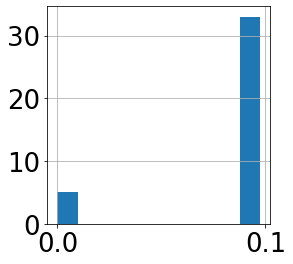

In [636]:
feature_stat['na percentage'].hist(bins=10, figsize=(4,4))

In [637]:
features

Series([], Name: col, dtype: object)

In [638]:
rows_stat,rows = FeatureEngineering.na_percentage_in_rows(df) 

In [639]:
rows_stat

,row,na percentage
0,22,0.861111
1,42,0.861111
2,62,0.861111
3,82,0.861111
4,102,0.861111
...,...,...
1068,10952,0.861111
1069,10969,0.861111
1070,10972,0.861111
1071,10989,0.861111


In [640]:
rows

0          22
1          42
2          62
3          82
4         102
        ...  
1068    10952
1069    10969
1070    10972
1071    10989
1072    10992
Name: row, Length: 1073, dtype: int64

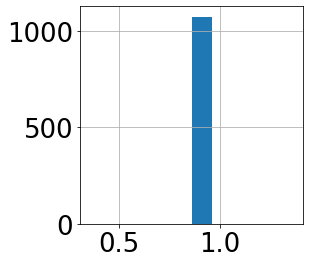

In [641]:
rows_stat['na percentage'].hist(bins=10, figsize=(4,4))

In [642]:
# feature engineering >> handle missing, arranging features, outliers treatment
df=FeatureEngineering.handle_missings(df)
df=FeatureEngineering.rearrange_features(df)

Series([], Name: col, dtype: object)


D:\programs\lib\site-packages\pandas\core\frame.py:5732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [643]:
# describe the dataset
df.iloc[:,0:3].describe()

,house_price,bedrooms,baths
count,9927.000000,9927.000000,9927.000000
mean,4131.650448,2.309761,1.832880
std,3851.726512,0.848633,0.958422
min,1695.000000,0.000000,1.000000
25%,2577.000000,2.000000,1.000000
50%,3088.000000,2.000000,2.000000
75%,4250.000000,3.000000,2.000000
max,25000.000000,5.000000,6.000000


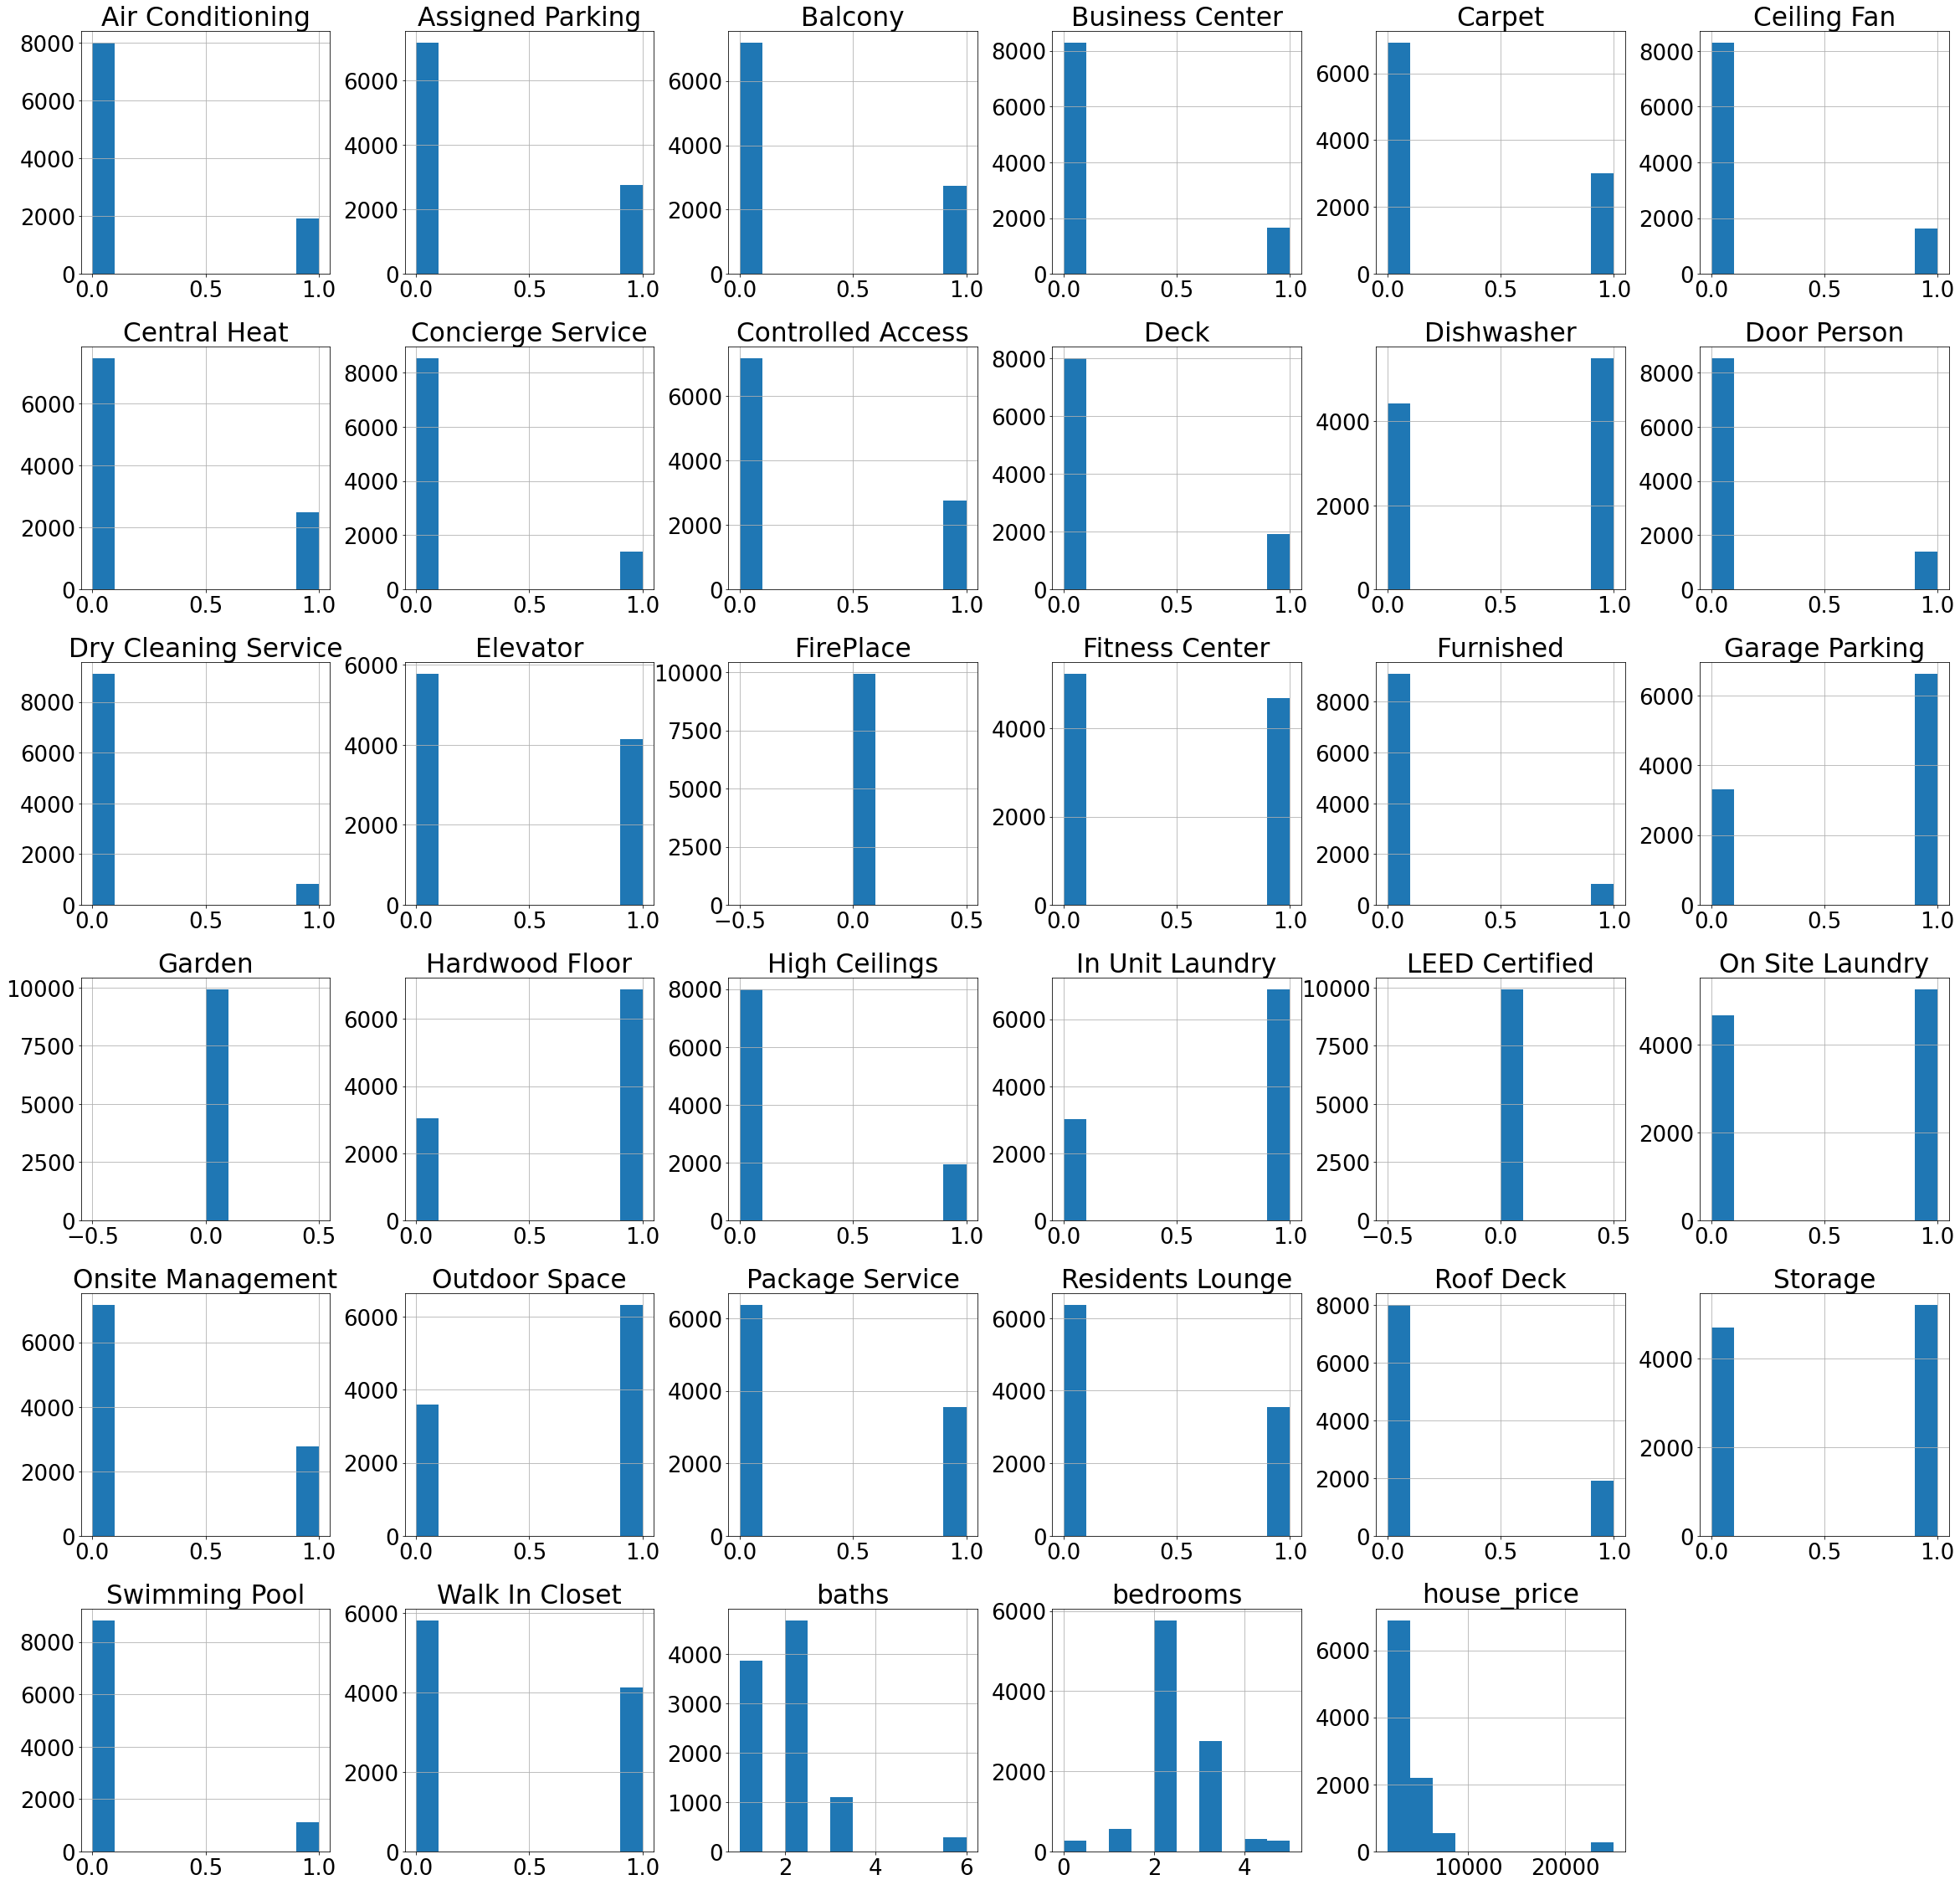

In [644]:
# get a plot for each feature
# shows the values of feature and the coressponding number of observations 
font = {'size'   : 26}
matplotlib.rc('font', **font)
df.hist(bins=10, figsize=(40,40))
plt.savefig('hist.png')

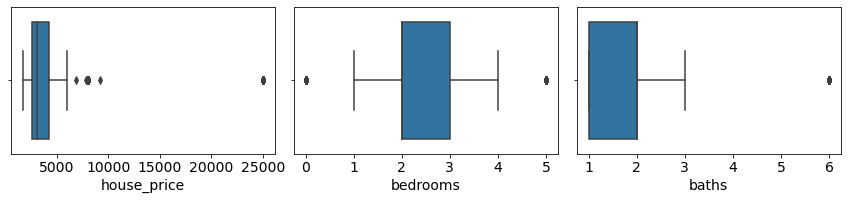

In [645]:
# outliers detection
font = {'size'   : 14}

matplotlib.rc('font', **font)
fig, axs = plt.subplots(1,3, figsize = (12,3))
plt1 = sns.boxplot(df['house_price'], ax = axs[0])
plt2 = sns.boxplot(df['bedrooms'], ax = axs[1])
plt3 = sns.boxplot(df['baths'], ax = axs[2])
plt.tight_layout()

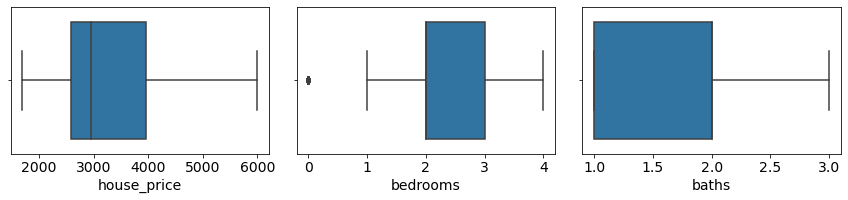

In [646]:
# outliers treatment 
df = FeatureEngineering.drop_outliers(df,'house_price')

font = {'size'   : 14}

matplotlib.rc('font', **font)
fig, axs = plt.subplots(1,3, figsize = (12,3))
plt1 = sns.boxplot(df['house_price'], ax = axs[0])
plt2 = sns.boxplot(df['bedrooms'], ax = axs[1])
plt3 = sns.boxplot(df['baths'], ax = axs[2])
plt.tight_layout()

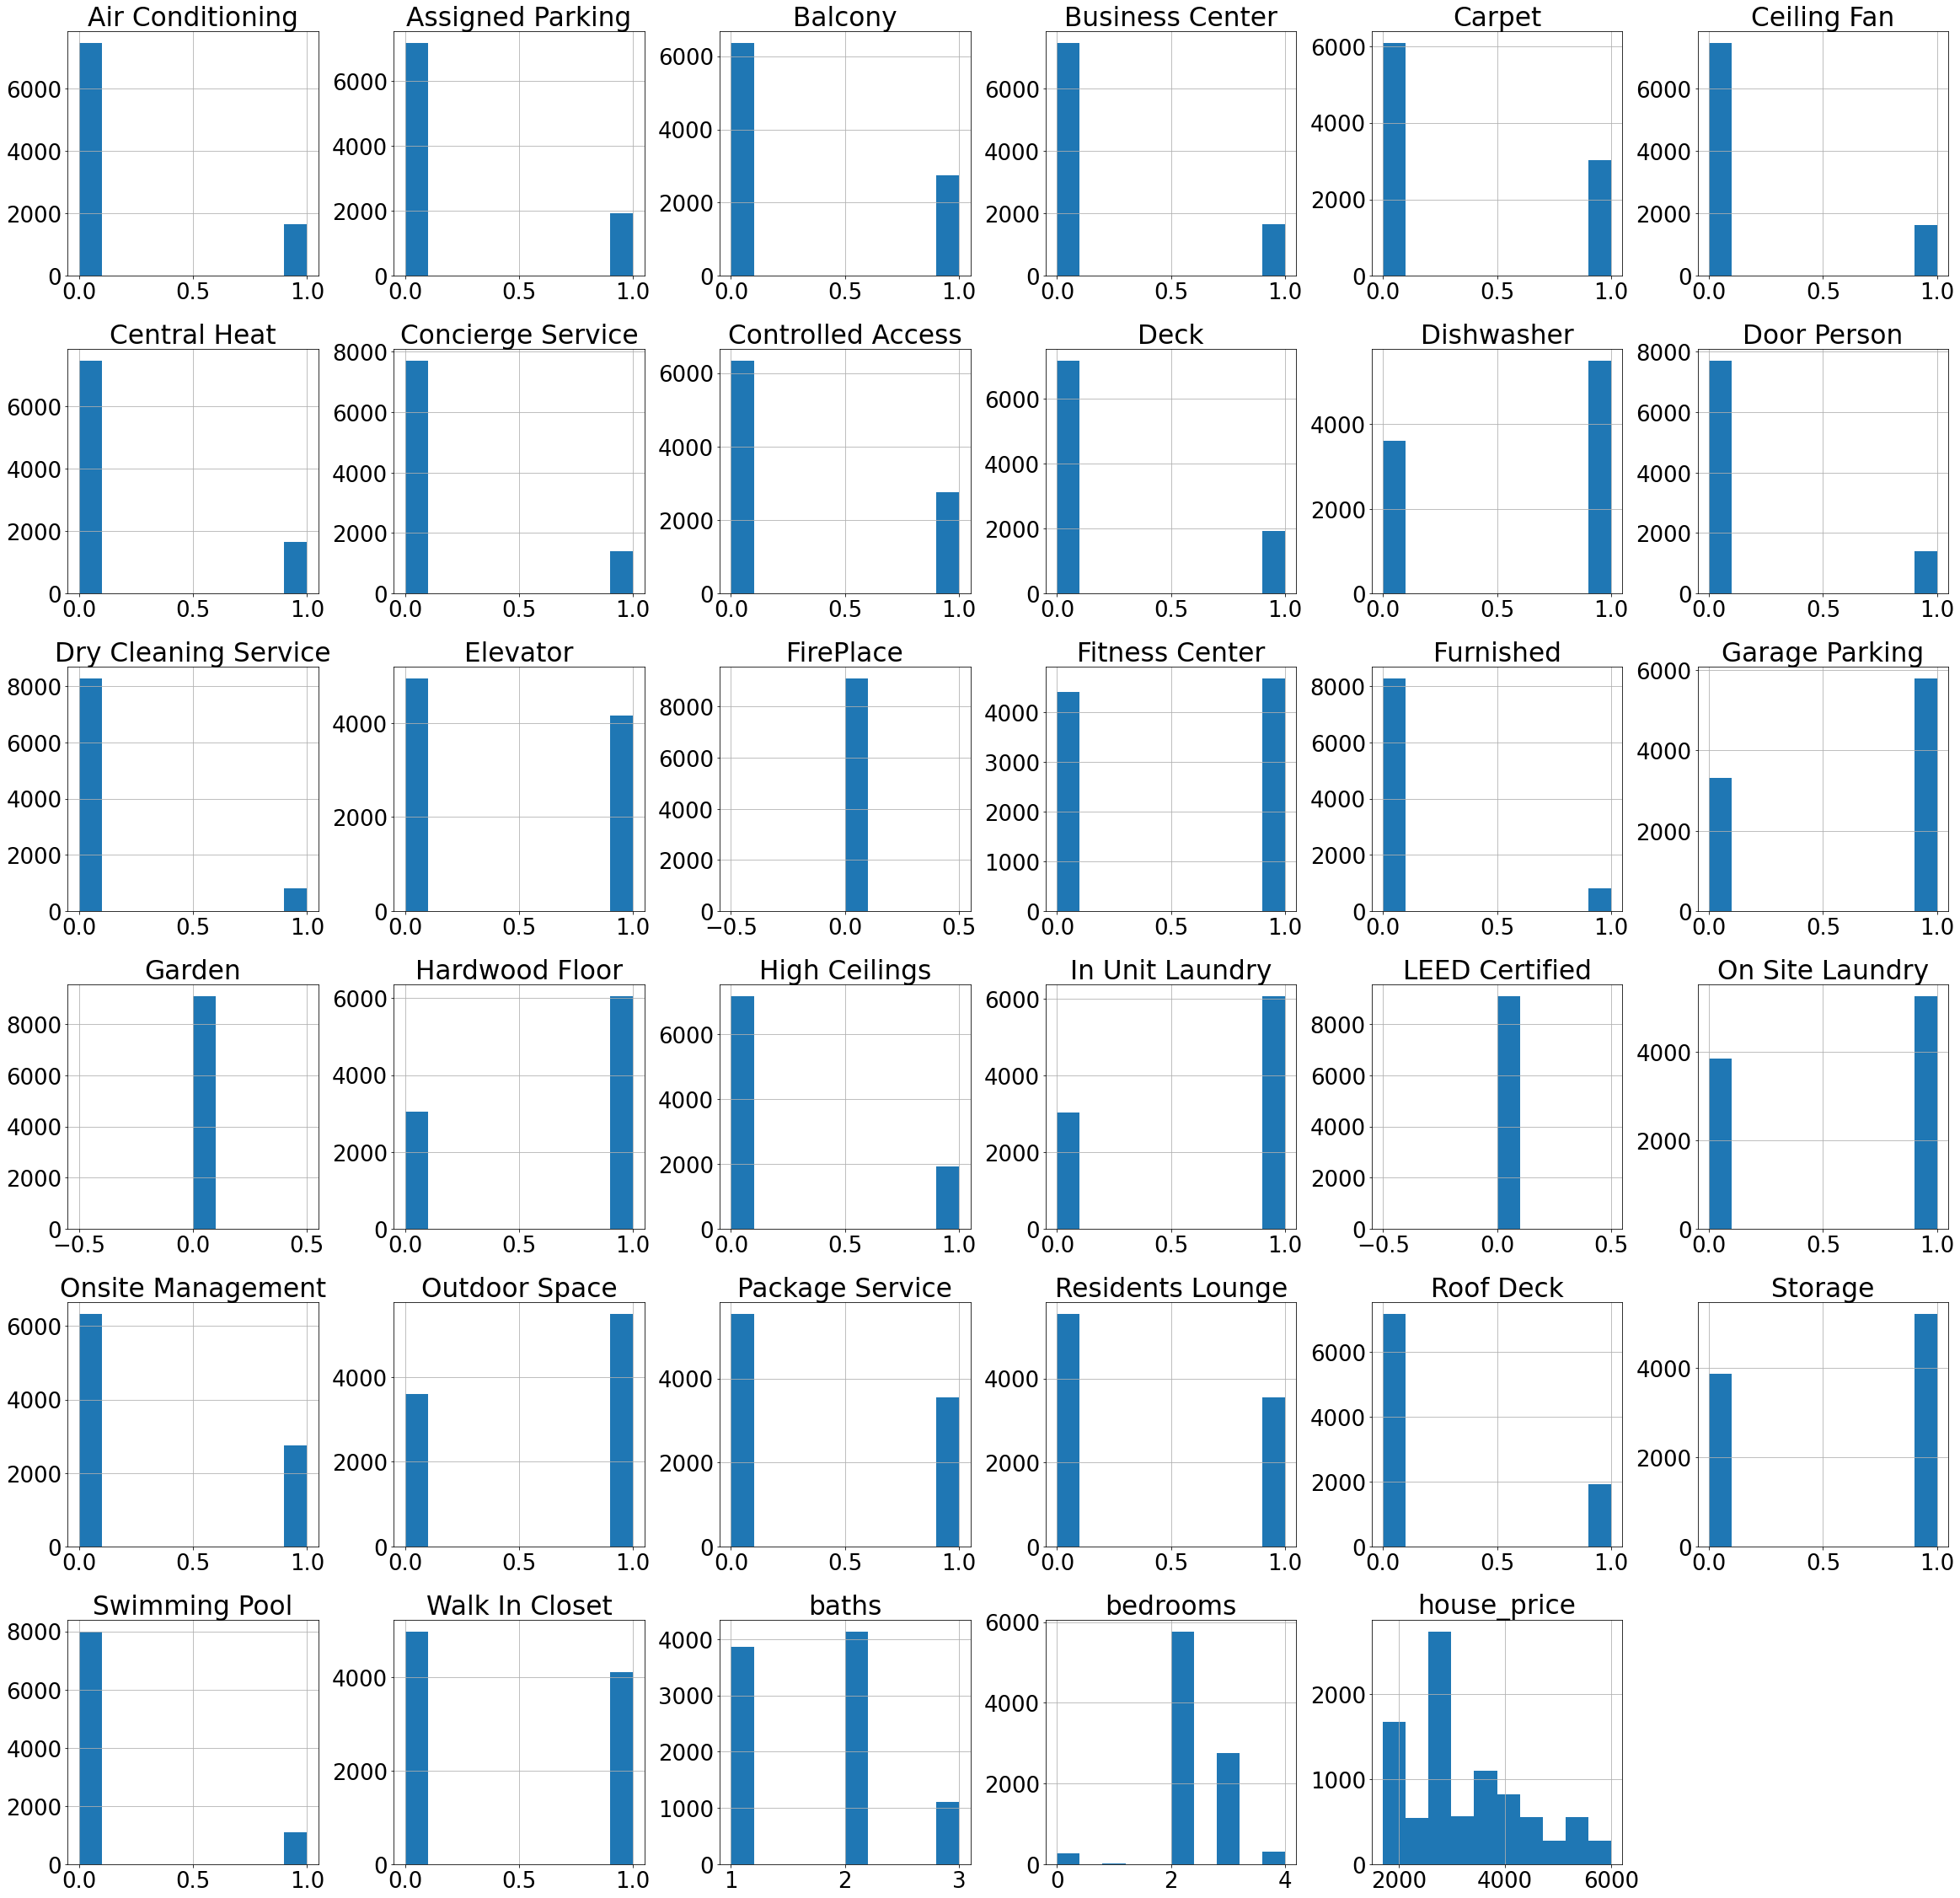

In [647]:
# get a plot for each feature
# shows the values of feature and the coressponding number of observations 
font = {'size'   : 26}
matplotlib.rc('font', **font)
df.hist(bins=10, figsize=(40,40))
plt.savefig('hist.png')

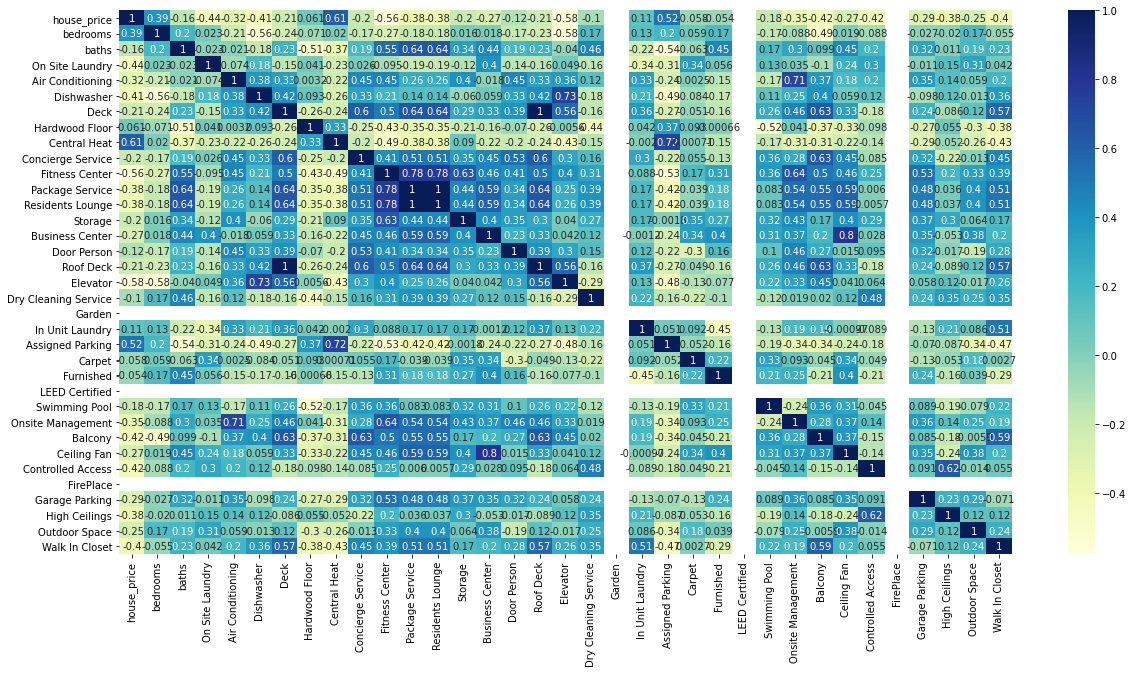

In [648]:
# check correlation between features as heatmap
font = {'size'   : 10}
matplotlib.rc('font', **font)
plt.figure(figsize = (20, 10))
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [649]:
# correlations to the rental price
corr_matrix = df.corr()

In [650]:
# correlation features to the house price
corr_matrix[corr_matrix.index == 'house_price'].T.sort_values('house_price')

,house_price
Elevator,-0.576413
Fitness Center,-0.555776
On Site Laundry,-0.438428
Balcony,-0.420216
Controlled Access,-0.417852
Dishwasher,-0.406438
Walk In Closet,-0.400993
Package Service,-0.382218
Residents Lounge,-0.381468
High Ceilings,-0.380064


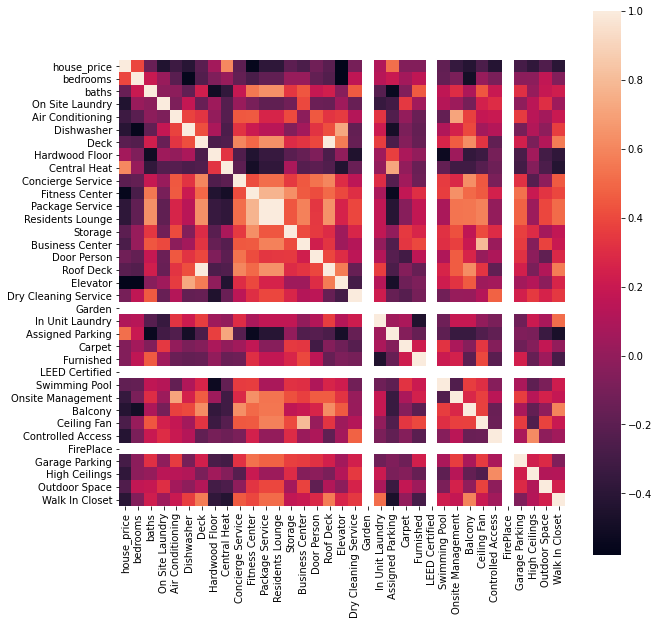

In [651]:
# draw the correlation as a heatmap
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, square=True)

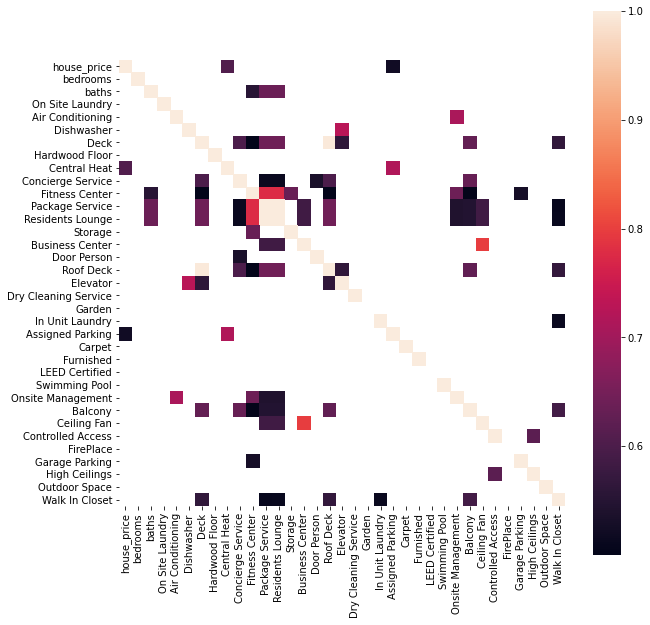

In [652]:
# draw the correlation more than 0.5 as a heatmap
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix[corr_matrix> 0.5], square=True)

In [653]:
# get all fetures with correlation more than 0.3 with house _price
t = corr_matrix[corr_matrix.index == 'house_price'].T.sort_values('house_price')
t[t['house_price']>=0.3]

,house_price
bedrooms,0.391235
Assigned Parking,0.523589
Central Heat,0.606449
house_price,1.000000


In [654]:
t[t['house_price']<=-0.3]

,house_price
Elevator,-0.576413
Fitness Center,-0.555776
On Site Laundry,-0.438428
Balcony,-0.420216
Controlled Access,-0.417852
Dishwasher,-0.406438
Walk In Closet,-0.400993
Package Service,-0.382218
Residents Lounge,-0.381468
High Ceilings,-0.380064


In [655]:
# get the name of features that don't have correlation with house price
t[t['house_price'].isna()].index

Index(['Garden', 'LEED Certified', 'FirePlace'], dtype='object')

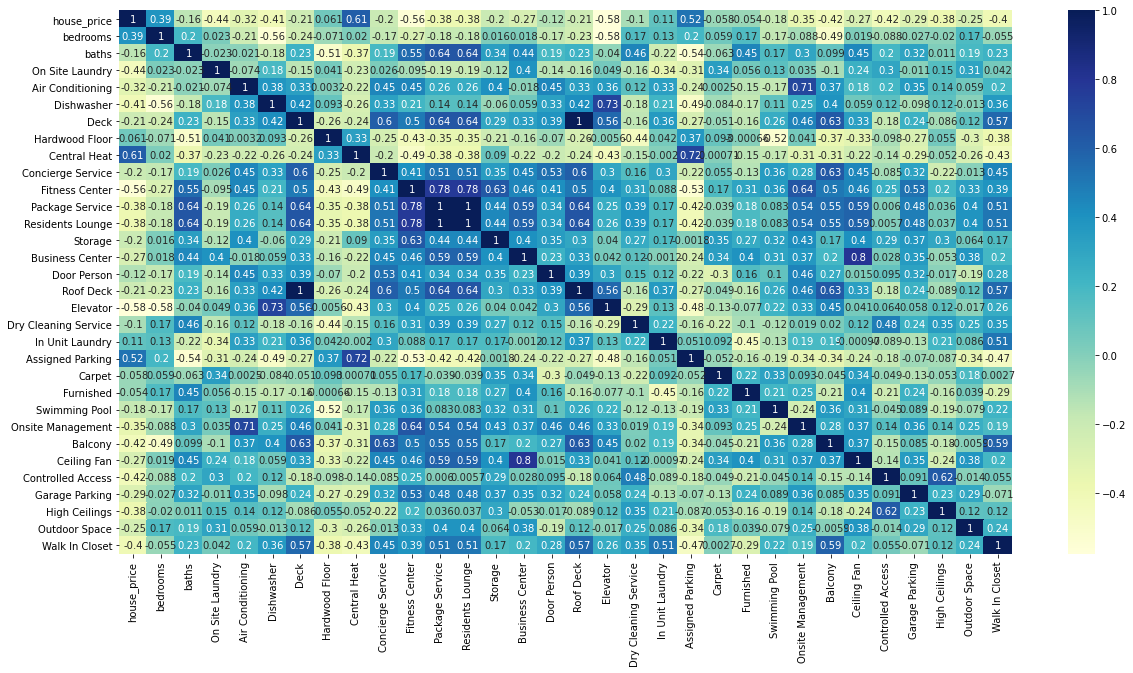

In [656]:
# drop column with no correlation 
df1 = df.drop(columns=t[t['house_price'].isna()].index)
plt.figure(figsize = (20, 10))
sns.heatmap(df1.corr(), annot = True, cmap="YlGnBu")
plt.show()

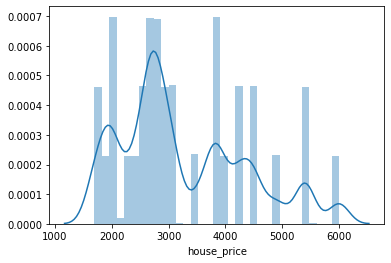

In [657]:
sns.distplot(df['house_price'])

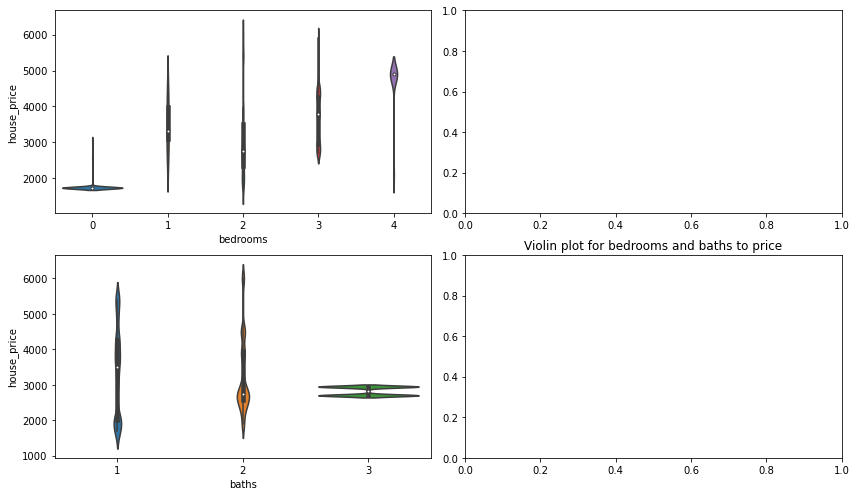

In [658]:

fig, axs = plt.subplots(2,2, figsize = (12,7))
plt1 = sns.violinplot(df['bedrooms'], df['house_price'], ax = axs[0,0])
plt2 = sns.violinplot(df['baths'], df['house_price'], ax = axs[1,0])

plt.tight_layout()


#plt.xticks(rotation=45)
plt.title("Violin plot for bedrooms and baths to price")
plt.savefig('violinplot.png')

No handles with labels found to put in legend.


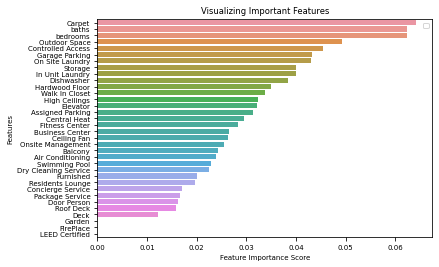

In [659]:
# get the most important features 
# these features is related to the features correlation table
selected_feat=FeatureSelection.select_features(df,'house_price')

In [660]:
class dataSplitter:
    '''
    Class dataSplitter to split data into train and test using selected features 
    '''
    def __init__(self,df,target_variable,selected_feat):
        #self.x = df.drop(target_variable, 1)
        self.x = df[selected_feat]
        self.y = df[target_variable]
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x,self.y,test_size=0.2,random_state=37)
    
    def scale_features(self):
        '''
        This function scale features usinf standardization 
        to have values of features between 1 and -1  
        '''
        pipeline = Pipeline([
            ('std_scalar', StandardScaler())
        ])

        # standardize x_train, x_test
        self.x_train = pipeline.fit_transform(self.x_train)
        self.x_test = pipeline.transform(self.x_test)

In [661]:
data= dataSplitter(df,'house_price',selected_feat)
data.scale_features()

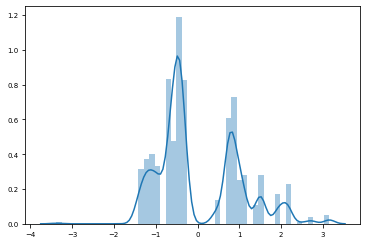

In [470]:
sns.distplot((data.x_test), bins=50);

In [552]:
class Model:

    '''
    Class Model have all validation and evaluation methods with save method
    '''
    def cross_val(self,model,x,y):
        '''
        This function calculate cross_val_score for model
        '''
        cv = KFold(n_splits=10, random_state=1, shuffle=True)
        # evaluate model
        pred = cross_val_score(model, x, y,cv=cv)
        logger.info('cross_val_score: {}'.format(pred.mean()))
        return pred.mean()



    def print_evaluate(self,true, predicted):  
        '''
        printing evaluation metrics
        '''
        mae, mse, rmse, r2_square=self.evaluate(true, predicted)
        logger.info('MAE: {}'.format(mae))
        logger.info('MSE: {}'.format(mse))
        logger.info('RMSE: {}'.format(rmse))
        logger.info('R2 Square: {}'.format(r2_square))
        logger.info('__________________________________')
        
        print('MAE:', mae)
        print('MSE:', mse)
        print('RMSE:', rmse)
        print('R2 Square', r2_square)
        print('__________________________________')


    def evaluate(self,true, predicted):
        '''
        calculate evaluation metrics for a model
        '''
        mae = mean_absolute_error(true, predicted)
        mse = mean_squared_error(true, predicted)
        rmse = np.sqrt(mean_squared_error(true, predicted))
        r2_square = r2_score(true, predicted)
        return mae, mse, rmse, r2_square   
    
    
    def SaveModel(self,model,filename='finalized_model.sav'):
        # Save the model as a pickle in a file
        # save the model to disk
        pickle.dump(model, open(filename, 'wb'))
        
        # some time later...
        # load the model from disk
    
        #loaded_model = pickle.load(open(filename, 'rb'))

In [783]:
class ModelTraining(Model):
    
    '''
    ModelTraining Class inhiret class Model to have evaluation metrics
    this class have 6 model to train and hyperparameter tuning to get the best prediction model
    '''
    def __init__(self, data, dataTune):
        '''Constructor'''
        # results of all metrics for all models
        self.results_df = pd.DataFrame()
        # data to use in training 
        self.data = data
        # data to use in hyper tuning 
        self.dataTune = dataTune
        
    def linearRegTrain(self):
        ''' to train a linear regression model'''
        logger.info('Training linear regression model')
        # define object of linear regression model
        model = LinearRegression(normalize=True)
        # train the model
        model.fit(self.data.x_train,self.data.y_train)
        # predict 
        test_pred = model.predict(self.data.x_test)
        train_pred = model.predict(self.data.x_train)
        
        # recording metric evaluation 
        print('Test dataset evaluation:\n_____________________________________')
        print_evaluate(self.data.y_test, test_pred)
        print('Train dataset evaluation:\n_____________________________________')
        print_evaluate(self.data.y_train, train_pred)
        
        # add all metrics data to a dataframe results_df
        self.results_df = pd.DataFrame(data=[["Linear Regression", *self.evaluate(self.data.y_test, test_pred) , self.cross_val(model,self.data.x_test,self.data.y_test)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
        # save the model 
        self.SaveModel(model,'LinReg.sav')
        return model
    

##################### Random Forest Regressor#########################   
    def RandomForestTrain(self):
        ''' train a Random Forest Regressor model'''
        logger.info('Training Random Forest Regressor model')
        # get the best hypertuned model for Random Forest Regressor
        model = self.HyperTuneRandomForest()
        # train model
        model.fit(self.data.x_train, self.data.y_train)
        # predictions
        test_pred = model.predict(self.data.x_test)
        train_pred = model.predict(self.data.x_train)
        # recording evaluation metrics
        print('Test set evaluation:\n_____________________________________')
        print_evaluate(self.data.y_test, test_pred)
        print('Train set evaluation:\n_____________________________________')
        print_evaluate(self.data.y_train, train_pred)
        # add all metrics data to a dataframe results_df
        results_df_1 = pd.DataFrame(data=[["Random Forest Regressor", *self.evaluate(self.data.y_test, test_pred), self.cross_val(model,self.data.x_test,self.data.y_test)]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
        self.results_df = self.results_df.append(results_df_1, ignore_index=True)
        #save model
        self.SaveModel(model,'RandForest.sav')
        return model
    
    def HyperTuneRandomForest(self):
        '''Random Forest Regressor hyper parameters tuning'''
        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt']
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]
        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}
        # defin object of RandomForestRegressor to hyper tune the parameter
        rf = RandomForestRegressor()
        # Random search of parameters, using 3 fold cross validation, 
        # search across 100 different combinations, and use all available cores
        rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
        # Fit the random search model
        rf_random.fit(self.dataTune.x_train, self.dataTune.y_train)
        logger.info('best param for: {}'.format(rf_random.best_params_))
        return rf_random.best_estimator_
    
###################### Gradient Boosting Regressor ####################

    def GradientBoostingTrain(self):
        '''Training Gradient Boosting Regressor model'''
        logger.info('Training Gradient Boosting Regressor model')
        # get the best model of Gradient Boosting Regressor after hyper parameters tuning
        model = self.HyperTuneGradientBoosting()
        # train the model
        model.fit(self.data.x_train, self.data.y_train)
        # prediction
        test_pred = model.predict(self.data.x_test)
        train_pred = model.predict(self.data.x_train)
        # recording evaluation metrics
        print('Test dataset evaluation:\n_____________________________________')
        print_evaluate(self.data.y_test, test_pred)
        print('Train dataset evaluation:\n_____________________________________')
        print_evaluate(self.data.y_train, train_pred)
        # add all metrics data to a dataframe results_df
        results_df_1 = pd.DataFrame(data=[["Gradient Boosting Regressor", *self.evaluate(self.data.y_test, test_pred), self.cross_val(model,self.data.x_test,self.data.y_test)]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
        self.results_df = self.results_df.append(results_df_1, ignore_index=True)
        # save model
        self.SaveModel(model,'GradBoost.sav')
        return model
    
    def HyperTuneGradientBoosting(self):
        '''Gradient Boosting Regressor hyper parameters tuning'''
        # hyper parameters
        params = {'n_estimators':[500, 1000, 1500, 2000], 'max_depth':[3, 5, 8],'random_state':[22,37,50]}
        # define object of GradientBoostingRegressor model
        gbr = GradientBoostingRegressor()
        # create GridSearchCV object to search for the best estimator
        gbr_grid = GridSearchCV(gbr, params, cv=5)
        gbr_grid.fit(self.dataTune.x_train, self.dataTune.y_train)
        logger.info('best param for: {}'.format(gbr_grid.best_params_))
        return gbr_grid.best_estimator_
    
#################### ElasticNet ####################

    def ElasticNetTrain(self):
        '''Training ElasticNet model'''
        logger.info('Training ElasticNet model')
        # hyperparameters to be tuned
        elastic_params = {'alpha':np.arange(0, 1, 0.01)}
        # hyperparameters tuning using GridSearchCV
        best_estim = GridSearchCV(ElasticNet(), param_grid=elastic_params).fit(self.dataTune.x_train, self.dataTune.y_train).best_estimator_
        # get the best model of ElasticNet after hyperparameters tuning using GridSearchCV
        model = best_estim
        # train the model
        model.fit(self.data.x_train, self.data.y_train)

        test_pred = model.predict(self.data.x_test)
        train_pred = model.predict(self.data.x_train)
        # recording evaluation metrics
        print('Test set evaluation:\n_____________________________________')
        print_evaluate(self.data.y_test, test_pred)
        print('====================================')
        print('Train set evaluation:\n_____________________________________')
        print_evaluate(self.data.y_train, train_pred)
        # add all metrics data to a dataframe results_df
        results_df_1 = pd.DataFrame(data=[["ElasticNet Regressor", *self.evaluate(self.data.y_test, test_pred), self.cross_val(model,self.data.x_test,self.data.y_test)]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
        self.results_df = self.results_df.append(results_df_1, ignore_index=True)
        #save model
        self.SaveModel(model,'Elastic.sav')
        return model

##################### Lasso ####################
    def LassoTrain(self): 
        '''Training Lasso model'''
        logger.info('Training Lasso model')
        # hyperparameters to be tuned
        lasso_params = {'alpha':np.arange(0, 1, 0.01)}
        # hyperparameters tuning using GridSearchCV
        best_estim = GridSearchCV(Lasso(), param_grid=lasso_params).fit(self.dataTune.x_train, self.dataTune.y_train).best_estimator_
        # get the best model of Lasso after hyperparameters tuning using GridSearchCV
        model = best_estim
        # train the model
        model.fit(self.data.x_train, self.data.y_train)

        test_pred = model.predict(self.data.x_test)
        train_pred = model.predict(self.data.x_train)
        # recording evaluation metrics
        print('Test set evaluation:\n_____________________________________')
        print_evaluate(self.data.y_test, test_pred)
        print('====================================')
        print('Train set evaluation:\n_____________________________________')
        print_evaluate(self.data.y_train, train_pred)
        # add all metrics data to a dataframe results_df
        results_df_1 = pd.DataFrame(data=[["Lasso Regressor", *self.evaluate(self.data.y_test, test_pred), self.cross_val(model,self.data.x_test,self.data.y_test)]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
        self.results_df = self.results_df.append(results_df_1, ignore_index=True)
        # save model
        self.SaveModel(model,'Lasso.sav')
        return model
    
##################### Ridge ####################
    def RidgeTrain(self):
        '''Training Ridge model'''
        logger.info('Training Ridge model')
        # hyperparameters to be tuned
        ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}
        # hyperparameters tuning using GridSearchCV
        best_estim = GridSearchCV(Ridge(), param_grid=ridge_params).fit(self.dataTune.x_train, self.dataTune.y_train).best_estimator_
        # get the best model of Ridge after hyperparameters tuning using GridSearchCV
        model = best_estim
        # train model
        model.fit(self.data.x_train, self.data.y_train)

        test_pred = model.predict(self.data.x_test)
        train_pred = model.predict(self.data.x_train)
        # recording evaluation metrics
        print('Test set evaluation:\n_____________________________________')
        print_evaluate(self.data.y_test, test_pred)
        print('====================================')
        print('Train set evaluation:\n_____________________________________')
        print_evaluate(self.data.y_train, train_pred)
        # add all metrics data to a dataframe results_df
        results_df_2 = pd.DataFrame(data=[["Ridge Regression", *self.evaluate(self.data.y_test, test_pred), self.cross_val(model,self.data.x_test,self.data.y_test)]], 
                                    columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
        self.results_df = self.results_df.append(results_df_2, ignore_index=True)
        # save model
        self.SaveModel(model,'Ridge.sav')
        return model

##################### KNN ####################
    def KNNTrain(self):
        '''Training KNeighbors Regressor model'''
        logger.info('Training KNeighbors Regressor model')
        # Define hyperparameters
        hp_params = {'n_neighbors': [100,200,300], 'weights': ['uniform','distance']}
        
        # Search for best hyperparameters and get the best estimator
        knr = GridSearchCV(estimator= KNeighborsRegressor(), param_grid=hp_params, scoring='r2').fit(self.dataTune.x_train, self.dataTune.y_train).best_estimator_
        # get the best model of Ridge after hyperparameters tuning using GridSearchCV
        model = knr
        # ttrain model
        model.fit(self.data.x_train, self.data.y_train)
        
        test_pred = model.predict(self.data.x_test)
        train_pred = model.predict(self.data.x_train)
        # recording evaluation metrics
        print('Test set evaluation:\n_____________________________________')
        print_evaluate(self.data.y_test, test_pred)
        print('====================================')
        print('Train set evaluation:\n_____________________________________')
        print_evaluate(self.data.y_train, train_pred)
        # add all metrics data to a dataframe results_df
        results_df_1 = pd.DataFrame(data=[["KNeighbors Regressor", *self.evaluate(self.data.y_test, test_pred), self.cross_val(model,self.data.x_test,self.data.y_test)]], 
                            columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', 'Cross Validation'])
        self.results_df = self.results_df.append(results_df_1, ignore_index=True)
        # save model
        self.SaveModel(model,'KNR.sav')
        return model   
#######################################################    
    def predict(self,model,x,y):
        '''function to use trained model to do predictions'''
        pred_y = model.predict(x)
        self.print_evaluate(y,pred_y)
        df = pd.DataFrame()
        df['True'] = y.tolist()
        df['Prediction'] = pred_y.tolist()
        logger.info('Prediction: {}'.format(df))
        return df
        


In [736]:
# prepare data for tuning 
d = pd.read_excel('data.xlsx')
d=d.drop(columns=['Unnamed: 0'])
d=d.astype('int')
d=FeatureEngineering.drop_outliers(d,'house_price')
d=FeatureEngineering.drop_outliers(d,'bedrooms')
d=FeatureEngineering.drop_outliers(d,'baths')
dataTune = dataSplitter(d,'house_price',selected_feat)


In [737]:
# scale features 
dataTune.scale_features()

In [738]:
# prepare data for training 
data = dataSplitter(df,'house_price',selected_feat)
# scale features
data.scale_features()

In [739]:
# define object of ModelTraining
training = ModelTraining(data,dataTune)

In [740]:
# train Linear Regressor
training.linearRegTrain()

Test dataset evaluation:
_____________________________________
MAE: 40.23436784100711
MSE: 9536.822206503935
RMSE: 97.6566546964616
R2 Square 0.9923666609296676
__________________________________
Train dataset evaluation:
_____________________________________
MAE: 39.75333613929674
MSE: 8592.453765898033
RMSE: 92.69548945821492
R2 Square 0.9932270840386546
__________________________________


LinearRegression(normalize=True)

In [541]:
# train Gradient Boosting Regressor
training.GradientBoostingTrain()

Test dataset evaluation:
_____________________________________
MAE: 14.50304787936265
MSE: 8925.687693441778
RMSE: 94.47585772800254
R2 Square 0.9928558172602329
__________________________________
Train dataset evaluation:
_____________________________________
MAE: 11.897523250240576
MSE: 4746.687108921946
RMSE: 68.89620533035144
R2 Square 0.9962584712400637
__________________________________


GradientBoostingRegressor(max_depth=5, n_estimators=1500, random_state=50)

In [542]:
# train Random Forest Regressor
training.RandomForestTrain()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.2min finished


Test set evaluation:
_____________________________________
MAE: 13.96389742539569
MSE: 4486.549810552294
RMSE: 66.98171250835779
R2 Square 0.9964089342111752
__________________________________
Train set evaluation:
_____________________________________
MAE: 11.951108783288078
MSE: 2384.2462022659724
RMSE: 48.82874360728496
R2 Square 0.998120641716666
__________________________________


RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400)

In [543]:
# train ElasticNet Regressor
training.ElasticNetTrain()

D:\programs\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\model_selection\_valid

Test set evaluation:
_____________________________________
MAE: 58.08834133400036
MSE: 13682.69016269226
RMSE: 116.97303177524408
R2 Square 0.9890482792753648
__________________________________
Train set evaluation:
_____________________________________
MAE: 59.469312494835094
MSE: 13654.589560795532
RMSE: 116.85285431171775
R2 Square 0.9892369059989621
__________________________________


D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291754.6347743906, tolerance: 207142.5253990232
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.01)

In [544]:
# train Lasso Regressor
training.LassoTrain()

D:\programs\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\model_selection\_valid

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1379332.811159919, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1615480.9598523688, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 991209.3133893039, tolerance: 351514.7637381255
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to in

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2611997.356991011, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3059119.6713588033, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1308526.8598296593, tolerance: 351514.7637381255
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to i

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3551462.1036470067, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4301296.427320205, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1655508.3896567763, tolerance: 351514.7637381255
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to i

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4044493.4563623453, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5283420.803065139, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1910605.0889606886, tolerance: 351514.7637381255
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to i

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4711593.214142961, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6042311.231433342, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2253014.4607992955, tolerance: 351514.7637381255
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to in

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5427980.176068591, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6645373.118701785, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2579293.5345407776, tolerance: 351514.7637381255
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to in

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6089704.010305693, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7288571.468632672, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3427985.728317054, tolerance: 351514.7637381255
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to inc

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6009550.985970547, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7796690.6370829325, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3871446.499450107, tolerance: 351514.7637381255
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to in

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6149139.8282851055, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7923370.104383735, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4378978.336328353, tolerance: 351514.7637381255
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to in

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6399300.910785079, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7948830.045575503, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4833473.011834378, tolerance: 351514.7637381255
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to inc

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6724188.843089417, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8032784.860293682, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5243690.437451894, tolerance: 351514.7637381255
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to inc

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7055539.162693871, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8111066.88215788, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5698530.123885313, tolerance: 351514.7637381255
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to incr

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7377693.103147329, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8166521.63751875, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6145878.695492726, tolerance: 351514.7637381255
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to incr

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6458609.2345806565, tolerance: 352172.9977877099
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7701786.783002848, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8245641.635886268, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to in

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6672525.219702691, tolerance: 352172.9977877099
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8008535.0032259775, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8407404.039575214, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to in

D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6777696.251521863, tolerance: 352172.9977877099
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8293068.102974255, tolerance: 351988.3401083945
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8589860.551494516, tolerance: 356114.2708975065
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to inc

Test set evaluation:
_____________________________________
MAE: 53.48491140520651
MSE: 12914.04888330313
RMSE: 113.63999684663463
R2 Square 0.9896635051212477
__________________________________
Train set evaluation:
_____________________________________
MAE: 54.01668896495305
MSE: 10965.948909755713
RMSE: 104.7184267918293
R2 Square 0.9913562001698568
__________________________________


D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1176700.1055551637, tolerance: 205728.1440354701
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1032794.4561040606, tolerance: 203203.25756660564
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 971194.2367972508, tolerance: 206234.81516660564
  model = cd_fast.enet_coordinate_descent(
D:\programs\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to

Lasso(alpha=0.64)

In [545]:
# train Ridge Regressor
training.RidgeTrain()

Test set evaluation:
_____________________________________
MAE: 107.1544386146183
MSE: 26080.571904108307
RMSE: 161.49480457311407
R2 Square 0.9791249281803249
__________________________________
Train set evaluation:
_____________________________________
MAE: 109.65882503010255
MSE: 29327.011209978584
RMSE: 171.251310097116
R2 Square 0.9768832759844521
__________________________________


Ridge(alpha=200)

In [546]:
# train Knieghbors Regressor
training.KNNTrain()

Test set evaluation:
_____________________________________
MAE: 16.451205785122255
MSE: 12849.365402565356
RMSE: 113.35504136369656
R2 Square 0.9897152782307834
__________________________________
Train set evaluation:
_____________________________________
MAE: 11.950263808738665
MSE: 2384.812605605936
RMSE: 48.834543159590794
R2 Square 0.9981201952548838
__________________________________


KNeighborsRegressor(n_neighbors=100, weights='distance')

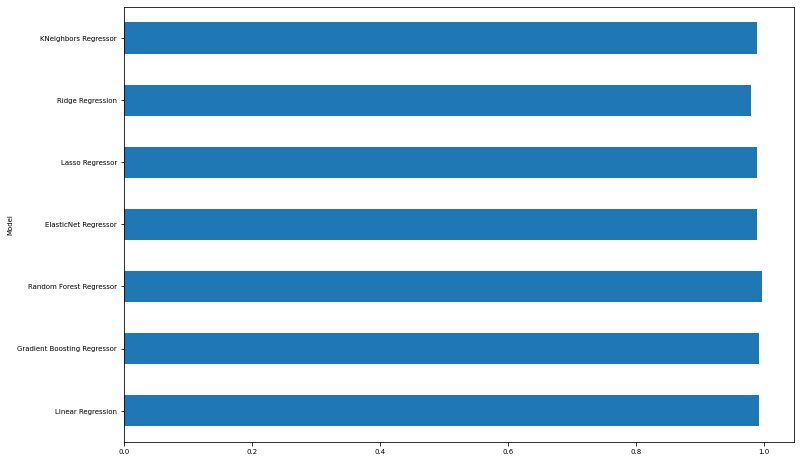

In [547]:
# show the results of metrics for each model #R2 Square
training.results_df.set_index('Model', inplace=True)
training.results_df['R2 Square'].plot(kind='barh', figsize=(12, 8))

In [624]:
# the best model to use 
#training.results_df.sort_values(by=['R2 Square']).iloc[-1,0]

# Making Predictions

In [776]:
# prepare data  
d = pd.read_excel('cleanDataSet.xlsx')
d=d.drop(columns=['Unnamed: 0'])
d=d.astype('int')
d=FeatureEngineering.drop_outliers(d,'house_price')
d=FeatureEngineering.drop_outliers(d,'bedrooms')
d=FeatureEngineering.drop_outliers(d,'baths')
d = d.sample(10)
dat = dataSplitter(d,'house_price',selected_feat)
# scale features 
dat.scale_features()

In [773]:
for model in ["Elastic.sav", "KNR.sav", "Lasso.sav", "LinReg.sav", "RandForest.sav", "Ridge.sav" ]:
    print(model)
    loaded_model = pickle.load(open(model, 'rb'))
    print(training.predict(loaded_model,dat.x_test,dat.y_test))
    print('<><><><><><><><><><><><><><><><><><><><><><><><>')
    

Elastic.sav
MAE: 569.7203521939698
MSE: 331485.08940069156
RMSE: 575.7474180582068
R2 Square 0.7886956055788198
__________________________________
   True   Prediction
0  1995  1342.190481
1  4500  4986.631185
<><><><><><><><><><><><><><><><><><><><><><><><>
KNR.sav
MAE: 6.821210263296962e-13
MSE: 5.169878828456423e-25
RMSE: 7.190186943645084e-13
R2 Square 1.0
__________________________________
   True  Prediction
0  1995      1995.0
1  4500      4500.0
<><><><><><><><><><><><><><><><><><><><><><><><>
Lasso.sav
MAE: 730.8288739243607
MSE: 534554.0551817891
RMSE: 731.1320367633941
R2 Square 0.65924976861014
__________________________________
   True   Prediction
0  1995  1285.223732
1  4500  5251.881480
<><><><><><><><><><><><><><><><><><><><><><><><>
LinReg.sav
MAE: 1036.3217709922806
MSE: 1179276.8304076476
RMSE: 1085.945132319146
R2 Square 0.2482727444702466
__________________________________
   True   Prediction
0  1995  1283.199442
1  4500  5860.842984
<><><><><><><><><><><><><><><